### Semantic kernel Vector Search with chat context/history 

In session 3, we walked through a simple example based on a fictitious company called Contoso, Ltd. In that example, an employee wanted to simply connect to company's database to retrieve some simple information or add a new record.

Now let's consider a different scenario. 

Let's assume the company has a chatbot that provides below basic support to customers:
1. Provides state of shipment
2. Provides state of return
2. Gives information about available products
3. Recommends best product based on customer needs and inventory

For an optimal experience, the chatbot needs to not only access product inventory, sales, shipment and return data, but also it would need to be able to pick up the conversation with each customer where it was left off, if required.

For this usecase, we are going to introduce and use below semantic kernel capabilities (in addition to what we covered before) to develop a solution:
- Chat completion **Agent** to manage the conversation thread and data access (one agent)
- Store and maintain **chat history** per customer and session, and retrieve the history for a customer/session when needed.
  -- We will persist the history in **CosmosDB**
- Vector search using Semantic Kernel Vector Store connectors
  -- Use company data as context to guide the conversation aka **RAG**



### Expanding the plugin

In previous session, we defined a class that enabled some basic functionalities to interact with the database. Now let's think about what data would the chatbot need to access and create a plugin to pull in that data:
- For this example we design the Chatbot so that it requires the customer to provide a unique identifier, and also a tracking number if they are following up on a previous conversation. 

Chatbot will need to access the following data to be able to assist the customer:
    - All sales data for the customer
    - All Return data for the customer
    - All basic customer info
    - All reviews and ratings provided by that customer
    - Data about all product offerings.

Below we will expand the plugin class to accomodate above requirements:


In [9]:
import psycopg2
from pandas import DataFrame
from typing import Optional
from semantic_kernel.functions import kernel_function


class Contoso_ChatPlugin:
    def __init__(self, db_uri: str):
        self.conn = psycopg2.connect(db_uri)
        self.cursor = self.conn.cursor()
        print("Connected to company's database successfully.")
    
    @kernel_function
    async def get_all_products(self) -> list[dict]:
        """Gets all movies info from the database."""
        query = """SELECT * FROM netflix_shows;"""
        self.cursor.execute(query)
        rows = self.cursor.fetchall()
        columns = [desc[0] for desc in self.cursor.description]
        try:
            products = DataFrame(rows, columns=columns)
            return products.to_dict(orient="records")  # <-- JSON serializable
        except Exception as e:
            print(f"Error fetching products: {e}")
            return None

    @kernel_function
    async def get_product_info(self, product_name: Optional[str] = None, product_id: Optional[int] = None) -> list[dict]:
        """Gets all movies information from the database given the name of the movie."""
        query = """SELECT 
                    show_id,
                    type,
                    title,
                    release_year,
                    listed_in,
                    description
                    from netflix_shows
                WHERE (LOWER(title) = LOWER(%(product_name)s) AND %(product_name)s IS NOT NULL)
                   """
        if not product_name and not product_id:
            print("No product name provided.")
            return None
        elif product_id:
            self.cursor.execute(query, {"product_name": None, "product_id": product_id})
        else:
            self.cursor.execute(query, {"product_name": product_name, "product_id": None})

            
        rows = self.cursor.fetchall()
        columns = [desc[0] for desc in self.cursor.description]
        try:
            products= DataFrame(rows, columns=columns)
            products.to_dict(orient="records")  # <-- JSON serializabl
            
            return products.to_dict(orient="records")  # <-- JSON serializabl
        except Exception as e:
            print(f"Error fetching product information: {e}")
            return None
        
   

    def close_connection(self):
        """Closes the database connection."""
        self.cursor.close()
        self.conn.close()
        print("Database connection closed.")
    



Now, let's define the agent that will manage the conversation with customers. As before, we need to add the chat completion service, as well as required plugins (to interact with postgreSQL data) to a kernel:

### Defining an example agent

Next, we will initiate a ChatCompletionAgent, and pass the kernel we just created to it to empower it for executing the tasks. We also add some instructions to define its main responsibilties:

In [10]:
from src.get_conn import get_connection_uri
from semantic_kernel.agents import ChatCompletionAgent
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.kernel import Kernel


conn_uri = get_connection_uri()
chat_kernel = Kernel()
chat_plugin = Contoso_ChatPlugin(db_uri=conn_uri)
chat_kernel.add_plugin(
        plugin = chat_plugin,
        plugin_name = "Chat_Plugin"
    ) 
support_agent = ChatCompletionAgent(
    service=AzureChatCompletion(),
    name="SupportAgent",
    kernel=chat_kernel,
    instructions="You are a support agent for Netfliix. You can answer questions about movies. Use the Contoso_ChatPlugin to access the company's database. Check the DBs fields: title, description and listed_in"
)

async def agent_chat(agent, message):
    """Function to handle chat with the agent."""
    res = await agent.get_response(message)
    print(f"Agent response: {res}")




Connection uri was rertieved successfully.
Connected to company's database successfully.


In [11]:
await agent_chat(support_agent, "Get me all information on a movie called The Starling")

Agent response: Here is the information on the movie The Starling:

- Title: The Starling
- Release Year: 2021
- Genres: Comedies, Dramas
- Description: A woman adjusting to life after a loss contends with a feisty bird that's taken over her garden — and a husband who's struggling to find a way forward.

Let me know if you need more details or recommendations!


In [12]:
chat_plugin.close_connection()

Database connection closed.


### Storing and retrieving chat history

As mentioned, chatbot will need to access history of previous converation if needed. Semantic Kernel agents use a class called ChatHistoryAgentThread to store conversation data and keep track of it. So we need to be able to store and retrieve chat history data for each conversation using an isntance of this class.

As mentioned, we choose to store chat history in an Azure Cosmos DB container due to the NoSQL nature of this data. So we need to develop a capability to store the converation history for each customer and chat session to a CosmosDB container.

We have created a database called "Contoso" which has a container called "customer_chats".

First let's connect to the database via the database client, which we can then use to get the container client that we can use to perform read/write operations:

### Vectorize product description and store in postgres as vector type


**Generate embeddings and prepare the vector store**: Create an instance of PostgresMemoryStore using semantic kernel vector store functionality .We will then use it to create a collection (aka table) to hold the vectors. It also provides the a function to insert the embeddings.
 


First we need to connect to an embedding service:

In [13]:
# connect to embedding service
from semantic_kernel.connectors.ai.open_ai import AzureTextEmbedding
import os
api_key = os.getenv("OPENAI_API_KEY")
embedding_service = AzureTextEmbedding(
    deployment_name=os.getenv('AZURE_OPENAI_EMBED_MODEL'),
    api_key= os.getenv('AZURE_OPENAI_KEY'),
    endpoint= os.getenv('AZURE_OPENAI_EMBED_ENDPOINT'),
    base_url= os.getenv('AZURE_OPENAI_BASE_EMBED_URL'))

In [14]:
import os
from dotenv import load_dotenv
from semantic_kernel.connectors.ai.open_ai import AzureTextEmbedding

load_dotenv()

embedding_service = AzureTextEmbedding(
    deployment_name=os.getenv("AZURE_OPENAI_EMBED_ID"),
    endpoint=os.getenv("AZURE_OPENAI_EMBED_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_KEY")
)


test_text = ["This is a test description for embedding."]
embedding = await embedding_service.generate_embeddings(test_text)
print("Embedding vector:", embedding[0])


Embedding vector: [-0.02318803  0.01333077 -0.00149535 ... -0.01457802 -0.0041709
 -0.00496551]


#### Ensure to enable vector extension for you Azure Database for PostgreSQL flexible server
<img src=".\imgs\pg_vec.jpeg" alt="description" width="500" height="300"/>
<!-- 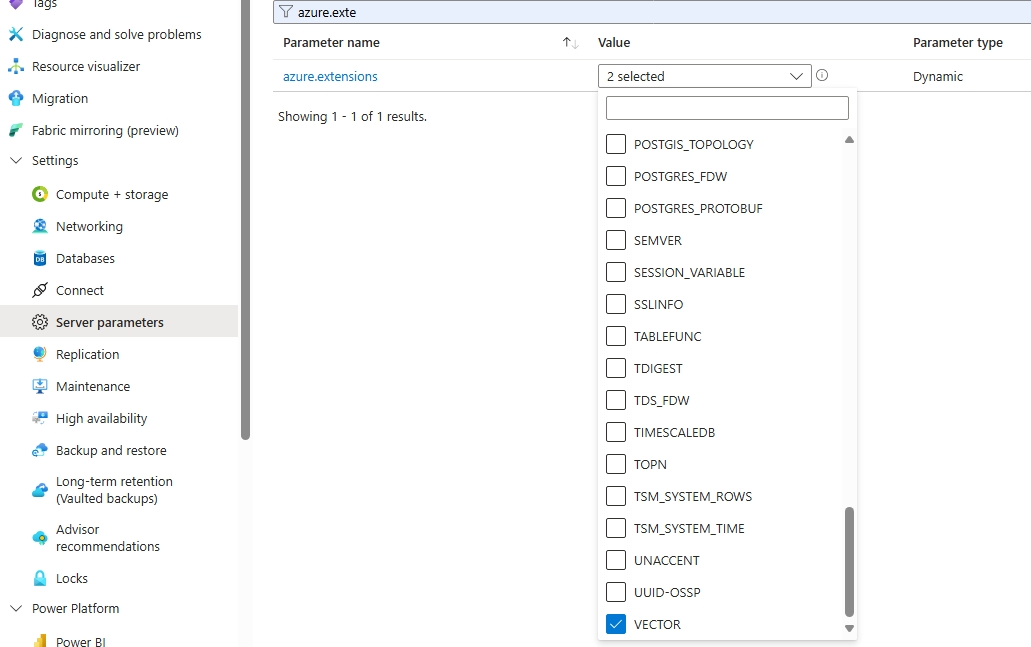 -->

#### Create a table and store vectors (using semantic kernel's vector store connector)

Let's first populate the vector table (it creates the index at the same time. HNSW is the only supported index for now. ETA for adding DiskANN support is by end of summer 2025.)

In [15]:
from semantic_kernel.connectors.memory.postgres import PostgresMemoryStore
from semantic_kernel.memory.memory_record import MemoryRecord
# connect to Azure postgres database
conn_uri = get_connection_uri()
conn = psycopg2.connect(conn_uri)
cur = conn.cursor()

# create an instance of PostgresMemoryStore
pg_store = PostgresMemoryStore(
    connection_string=conn_uri,
    default_dimensionality= 1536
)


# create a table for storing product description vectors
res = await pg_store.create_collection(
    collection_name="movie_desc_sk",
    dimension_num=1536)

# generate embeddings for product descriptions and store them in the product_desc_vec table
cur.execute("SELECT show_id, description FROM netflix_shows")
for row in cur.fetchall():
    prod_id, desc = row
    print(prod_id)
    embedding = (await embedding_service.generate_embeddings([desc]))[0]
    # change type of embedding to memory record
    memory_record = MemoryRecord(
        id=str(prod_id),           
        embedding=embedding, 
        text =  desc,    
        description="",
        additional_metadata="",
        is_reference=False,
        external_source_name=""

    )
    # upsert the memory record into the PostgresMemoryStore and also builds the index
    await pg_store.upsert(
        collection_name="movie_desc_sk",
        record=memory_record
    )
await pg_store.close()

conn.commit()
conn.close()


Connection uri was rertieved successfully.
s1
s10
s100
s101
s102
s103
s104
s105
s106
s107
s108
s1000
s1040
s1078
s1001
s1002
s1003
s1004
s1005
s1006
s1007
s1008
s1009
s1010
s1011
s1012
s1013
s1014
s1015
s1016
s1017
s1018
s1019
s1020
s1021
s1022
s1023
s1024
s1025
s1026
s1027
s1028
s1029
s1030
s1031
s1032
s1033
s1034
s1035
s1036
s1037
s1038
s1039
s1041
s1042
s1043
s1044
s1045
s1046
s1047
s1048
s1049
s1050
s1051
s1052
s1053
s1054
s1055
s1056
s1057
s1058
s1079
s1059
s1060
s1061
s1062
s1063
s1064
s1065
s1066
s1067
s1068
s1069
s1070
s1071
s1072
s1073
s1074
s1075
s1076
s1077
s1080
s1081
s1082
s1083
s1084
s1085
s1086
s1087
s1088


##### Example of getting top N results using sk's memory store functionality:

In [16]:
from typing import List, Tuple
from semantic_kernel.functions import kernel_function
from src.get_conn import get_connection_uri
import numpy as np
from semantic_kernel.connectors.memory.postgres import PostgresMemoryStore
from semantic_kernel.memory.memory_record import MemoryRecord


# we define it as a kernel function so that it can be used in the agent later
@kernel_function
async def get_similar_products_sk(embedding: np.ndarray , limit:int=3, collection_name="movie_desc_sk") -> List[Tuple[MemoryRecord, float]]:
    """Returns the most similar products to the question."""
    # connect to Azure postgres database
    conn_uri = get_connection_uri()

    # create an instance of PostgresMemoryStore
    pg_store = PostgresMemoryStore(
        connection_string=conn_uri,
        default_dimensionality= 1536
    )

    
    res = await pg_store.get_nearest_matches(
        collection_name=collection_name,
        embedding=embedding,
        limit=limit
    )
    await pg_store.close()  # Close the connection to the PostgresMemoryStore
    return res

In [17]:
example_embedding = (await embedding_service.generate_embeddings(["Movies about time machines"]))[0]
res= await get_similar_products_sk(example_embedding, limit=3)
for r in res:
    memory_record, score = r  # get_nearest_match returns a tuple (MemoryRecord, score)
    print("ID:", memory_record.id)
    print("Text:", memory_record.text)
    print("Score:", score)

Connection uri was rertieved successfully.
ID: s1007
Text: A time machine sends Motu and Patlu back to the dinosaur period, but the real trouble starts when the reptiles travel back to the present day with them!
Score: 0.8224223361956046
ID: s1037
Text: While searching for their missing archaeology professor, a group of students discovers a cave where time passes differently than it does on the surface.
Score: 0.8111736549346094
ID: s101
Text: An intergalactic device transforms toy cars into robots: the Tobots! Working with friends to solve mysteries, they protect the world from evil.
Score: 0.8083315859236281
